# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

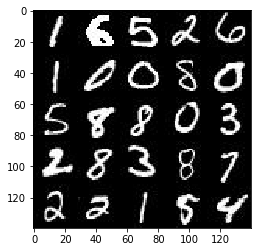

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

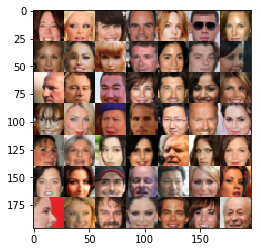

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    t_real_imgs = tf.placeholder( tf.float32, shape=[ None, image_width, image_height, image_channels ], name='real_images' )
    t_z_data    = tf.placeholder( tf.float32, shape=[ None, z_dim ], name='z_input')
    learn_rate  = tf.placeholder( tf.float32, name='learning_rate' )

    return (t_real_imgs, t_z_data, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Notes:  
    # Build a convolutional neural network
    # 1 fully connected layer at end
    # batch_norm between the layers, except for the first to second
    # no max pool layers
    # downsample is done with stride in conv layers
    # final layer is flattened connected to single sigmoid unit
    # leaky relu activations
    
    #num_units = 128
    alpha     = 0.2
    
    # Leveraging code snippets from Intro_to_GANs notebook in the deep-learning repo under gan_mnist folder
    # as well as the DCGAN notebook from the dcgan-svhn folder
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input images:  28 x 28 x 3, with pixel values in range -0.5 to 0.5
        # Adopt general policy of increasing depth by 2 with each layer,
        # and downsample by a factor of 2
        img1  = tf.layers.conv2d( images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum( alpha * img1, img1 )
        # 14 x 14 x 56 out
        
        img2 = tf.layers.conv2d( relu1, 112, 5, strides=2, padding='same')
        b_norm2 = tf.layers.batch_normalization( img2, training=True )
        relu2 = tf.maximum( alpha * b_norm2, b_norm2)
        # 7 x 7 x 112 out
        
        # at this point, the image size is no longer a factor of 2. 
        # could try different strides or padding.
        # just going to see how this model works as is first, then
        # consider making network deeper if results are poor.
        
        # Flatten
        flat_layer = tf.reshape( relu2, (-1, 7*7*112))
      
        logits = tf.layers.dense( flat_layer, 1 )
        ouput = tf.sigmoid( logits )

    return (ouput, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Leveraging code snippets from the DCGAN notebook in the dcgan-svhn folder of deep-learning repo
    # Start out with a deep and narrow network, that eventually gets shallower and flatter until reaching
    # size of 28 x 28 x 3
    my_reuse = not is_train
    with tf.variable_scope('generator', reuse=my_reuse):
        g_alpha = 0.2
        
        x1 = tf.layers.dense( z, 7 * 7 * 512 )
                
        x1 = tf.reshape( x1, (-1, 7, 7, 512 ))
        x1 = tf.layers.batch_normalization( x1, training = is_train)
        x1 = tf.maximum( g_alpha * x1, x1 )   # leaky ReLU
        # output size:  7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization( x2, training=is_train)
        x2 = tf.maximum( g_alpha * x2, x2 )   # leaky ReLU
        # 14 x 14 x 256
        
        # output layer
        logits = tf.layers.conv2d_transpose( x2, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x 3
        
        gen_out = tf.tanh( logits )
        
        return gen_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    gen_model = generator( input_z, out_channel_dim, is_train=True )
    
    # take real image input
    dsc_model_real, dsc_logits_real = discriminator(input_real, reuse=False)
    # take generator input
    dsc_model_fake, dsc_logits_fake = discriminator(gen_model, reuse=True)
    
    # Calculate loss
    dsc_loss_real = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_real, labels=tf.ones_like(dsc_model_real)))
    dsc_loss_fake = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.zeros_like(dsc_model_fake)))
    
    gen_loss      = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.ones_like(dsc_model_fake)))
    
    dsc_loss = dsc_loss_real + dsc_loss_fake
    
    return (dsc_loss, gen_loss )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dsc_vars = [ var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [ var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS)):
        dsc_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dsc_vars)
        gen_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return (dsc_train_op, gen_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    tf.reset_default_graph()
    
    # Like the __init__ section of DCGAN.ipynb notebook
    # model_inputs(image_width, image_height, image_channels, z_dim)
#    print( "image_width    = ", data_shape[1] )
#    print( "image_height   = ", data_shape[2] )
#    print( "batch_size     = ", batch_size )
#    print( "z_dim          = ", z_dim )
    
    # model_inputs(image_width, image_height, image_channels, z_dim)
    real_imgs, z_data, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # model_loss(input_real, input_z, out_channel_dim)
    dsc_loss, gen_loss = model_loss(real_imgs, z_data, data_shape[3])
    
    # model_opt(d_loss, g_loss, learning_rate, beta1)
    dsc_train_op, gen_train_op = model_opt(dsc_loss, gen_loss, learning_rate, beta1)

    samples, losses = [], []
    
    print_cycle = 10
    show_cycle  = 100
    steps       = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for generator
                batch_z = np.random.uniform( -0.5, 0.5, size=(batch_size, z_dim ) )
                
                # Run optimizers
                # ISSUES HERE --------------------------------------------------------------
                _ = sess.run( dsc_train_op, feed_dict={ real_imgs: batch_images, 
                                                        z_data: batch_z })
                # ISSUES HERE --------------------------------------------------------------
                
                _ = sess.run( gen_train_op, feed_dict={ z_data: batch_z,
                                                        real_imgs: batch_images } )
                
                if steps % print_cycle == 0:
                    train_loss_dsc = dsc_loss.eval({ z_data: batch_z, real_imgs: batch_images }) 
                    train_loss_gen = gen_loss.eval({ z_data: batch_z })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dsc),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                    
                    # Save losses to view after training
                    losses.append((train_loss_dsc, train_loss_gen))                    
                
                if steps % show_cycle == 0:
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
        
        #saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8446... Generator Loss: 0.0980
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 2.3607... Generator Loss: 0.3281
Epoch 1/2... Discriminator Loss: 2.6116... Generator Loss: 0.3676
Epoch 1/2... Discriminator Loss: 2.2788... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 1.9242... Generator Loss: 0.4898
Epoch 1/2... Discriminator Loss: 1.9439... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.7773... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.7018


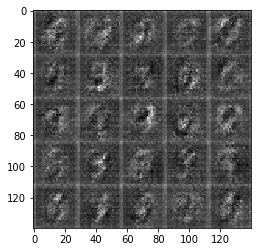

Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.9018
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 0.9244
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 1.5646
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.0100
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 1.0804
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 0.6897... Generator Loss: 1.3722


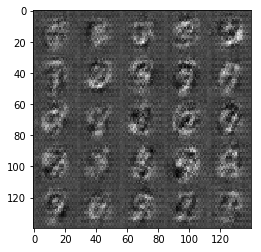

Epoch 1/2... Discriminator Loss: 1.1126... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.0272
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 1.2066
Epoch 1/2... Discriminator Loss: 1.6615... Generator Loss: 0.2639
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 1.3814
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 1.3730


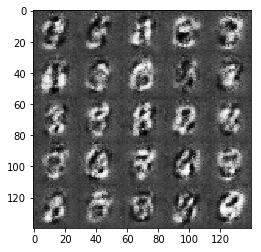

Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.8904
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 1.1196
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 1.3513
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.0518... Generator Loss: 0.5974
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.2448
Epoch 1/2... Discriminator Loss: 0.7131... Generator Loss: 1.1132
Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 1.3865
Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 1.6957


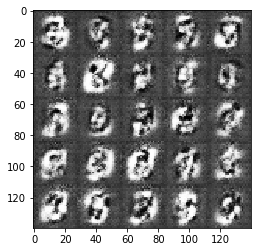

Epoch 1/2... Discriminator Loss: 0.6881... Generator Loss: 1.4946
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.5129
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 1.3424
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 1.5616
Epoch 2/2... Discriminator Loss: 0.5562... Generator Loss: 1.8378
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 0.9708
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 0.7736


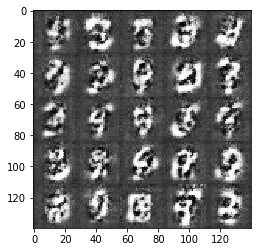

Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 1.9063
Epoch 2/2... Discriminator Loss: 0.5276... Generator Loss: 2.3749
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 3.0348
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 1.6769
Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 1.6285
Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 2.4892
Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 2.9597
Epoch 2/2... Discriminator Loss: 0.4674... Generator Loss: 2.3565
Epoch 2/2... Discriminator Loss: 0.4196... Generator Loss: 1.7198


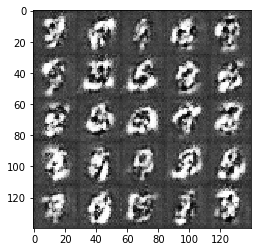

Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 2.5900
Epoch 2/2... Discriminator Loss: 0.3739... Generator Loss: 2.5808
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 2.1859
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 3.1433
Epoch 2/2... Discriminator Loss: 0.3397... Generator Loss: 1.7412
Epoch 2/2... Discriminator Loss: 0.3390... Generator Loss: 2.3982
Epoch 2/2... Discriminator Loss: 0.5423... Generator Loss: 3.1516
Epoch 2/2... Discriminator Loss: 0.2934... Generator Loss: 2.5299
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 2.6842
Epoch 2/2... Discriminator Loss: 0.3679... Generator Loss: 3.3421


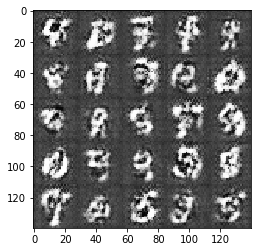

Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 1.9583
Epoch 2/2... Discriminator Loss: 0.2898... Generator Loss: 2.7665
Epoch 2/2... Discriminator Loss: 0.2471... Generator Loss: 2.7362
Epoch 2/2... Discriminator Loss: 0.4581... Generator Loss: 3.5203
Epoch 2/2... Discriminator Loss: 0.3240... Generator Loss: 2.5203
Epoch 2/2... Discriminator Loss: 0.2817... Generator Loss: 2.3577
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 3.8924
Epoch 2/2... Discriminator Loss: 0.2396... Generator Loss: 2.1446
Epoch 2/2... Discriminator Loss: 0.3030... Generator Loss: 2.9364
Epoch 2/2... Discriminator Loss: 0.2708... Generator Loss: 1.8904


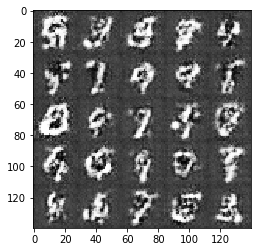

Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 2.8149
Epoch 2/2... Discriminator Loss: 0.2320... Generator Loss: 3.5922
Epoch 2/2... Discriminator Loss: 0.3671... Generator Loss: 1.5513
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 0.4737... Generator Loss: 1.3104
Epoch 2/2... Discriminator Loss: 0.4938... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.0146
Epoch 2/2... Discriminator Loss: 0.4033... Generator Loss: 1.4550
Epoch 2/2... Discriminator Loss: 0.4124... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.4712... Generator Loss: 1.2223


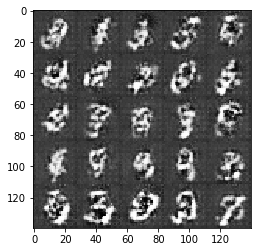

Epoch 2/2... Discriminator Loss: 0.4255... Generator Loss: 1.3853
Epoch 2/2... Discriminator Loss: 0.5333... Generator Loss: 1.0936
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 0.8474


IndexError: list index out of range

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.